In [6]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

In [7]:
from glob import glob
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [8]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 40
CHANNELS = 3
DATA = r'Hair Diseases - Final'

input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
NUMBER_OF_CLASSES = 10

In [9]:
folders = glob(rf"{DATA}/train")
folders

['Hair Diseases - Final/train']

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,   
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    shear_range=0.1,        
    zoom_range=0.1,        
    horizontal_flip=True,   
    fill_mode='nearest'
)
validate_data = ImageDataGenerator(
    rescale = 1./255
)
test_data = ImageDataGenerator(
    rescale = 1./255
)

In [17]:
trainning_dataset = train_data.flow_from_directory(
    rf"{DATA}/train",
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True
)

Found 13151 images belonging to 10 classes.


In [18]:
val_dataset = validate_data.flow_from_directory(
    rf"{DATA}/val",
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1524 images belonging to 10 classes.


In [19]:
test_dataset = test_data.flow_from_directory(
    rf"{DATA}/test",
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False
)

Found 1200 images belonging to 10 classes.


In [20]:
for x, y in trainning_dataset:
    print("x:",x[0])
    print("y:",y[0])
    print("shape:")
    print(x.shape)
    print(y.shape)
    break

x: [[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  ...
  [8.9624363e-01 8.4951514e-01 8.2133150e-01]
  [5.7601887e-01 5.5489612e-01 5.4095685e-01]
  [0.0000000e+00 2.1502569e-03 3.5426242e-03]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  ...
  [8.9629716e-01 8.4967566e-01 8.2157230e-01]
  [5.6986338e-01 5.4900825e-01 5.3517610e-01]
  [0.0000000e+00 2.1234939e-03 3.5961499e-03]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  ...
  [8.9635068e-01 8.4983629e-01 8.2181317e-01]
  [5.6370795e-01 5.4312044e-01 5.2939528e-01]
  [0.0000000e+00 2.0967310e-03 3.6496755e-03]]

 ...

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 

In [21]:
x , y =trainning_dataset[0]


In [22]:
class_name = trainning_dataset.class_indices
class_name

{'Alopecia Areata': 0,
 'Contact Dermatitis': 1,
 'Folliculitis': 2,
 'Head Lice': 3,
 'Lichen Planus': 4,
 'Male Pattern Baldness': 5,
 'Psoriasis': 6,
 'Seborrheic Dermatitis': 7,
 'Telogen Effluvium': 8,
 'Tinea Capitis': 9}

In [23]:
from keras_multi_head import MultiHeadAttention
inputs = layers.Input(shape=input_shape)
# Block 1
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
# Skip connection 1
skip1 = x

# Block 2
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
# Attention + Skip connection 1
x = layers.Permute((3, 1, 2))(x)
x = layers.Reshape((64, 30 * 30))(x)
x = MultiHeadAttention(head_num=30, name='Multi-Head1')(x)
x = layers.Reshape((64, 30, 30))(x)
x = layers.Permute((2, 3, 1))(x)

# Resize skip1_resized to match x using Conv2D with strides or cropping
skip1_resized = layers.Conv2D(filters=64, kernel_size=1, activation='linear')(skip1)
skip1_resized = layers.Cropping2D(cropping=((1, 1), (1, 1)))(skip1_resized)  # Adjust to match dimensions
x = layers.UpSampling2D(size=(2, 2))(x)  # Upsample x to match skip connection size

# Adding skip connection 1
x = layers.add([x, skip1_resized])

# Block 3
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
# Skip connection 2
skip2 = x

# Block 4
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
# Attention + Skip connection 2
x = layers.Permute((3, 1, 2))(x)
x = layers.Reshape((256, 13 * 13))(x)  # Correct reshape
x = MultiHeadAttention(head_num=13, name='Multi-Head3')(x)
x = layers.Reshape((256, 13, 13))(x)
x = layers.Permute((2, 3, 1))(x)

# Resize skip2 to match x
skip2_resized = layers.Conv2D(filters=256, kernel_size=1, activation='linear')(skip2)
skip2_resized = layers.MaxPooling2D(pool_size=2, strides=2)(skip2_resized)  # Downsample to match x
skip2_resized = layers.Cropping2D(cropping=((0, 1), (0, 1)))(skip2_resized)  # Crop to match x shape
x = layers.add([x, skip2_resized])

# Block 5
x = layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
# Skip connection 3
skip3 = x

# Attention + Skip connection 3
x = layers.Permute((3, 1, 2))(x)
x = layers.Reshape((512, 5 * 5))(x)  # Adjust reshape based on current shape
x = MultiHeadAttention(head_num=5, name='Multi-Head4')(x)
x = layers.Reshape((512, 5, 5))(x)
x = layers.Permute((2, 3, 1))(x)

# Adding skip connection 3
x = layers.add([x, skip3])

# Final layers
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(x)

# Define the model
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 124, 124,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 60, 60,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 64, 30,    │          0 │ max_pooling2d_1[… │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 900)   │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Multi-Head1         │ (None, 64, 900)   │  3,243,600 │ reshape[0][0]     │
│ (MultiHeadAttentio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 30,    │          0 │ Multi-Head1[0][0] │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 30, 30,    │          0 │ reshape_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 60, 60,    │          0 │ permute_1[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d          │ (None, 60, 60,    │          0 │ conv2d_3[0][0]    │
│ (Cropping2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 60,    │          0 │ up_sampling2d[0]… │
│                     │ 64)               │            │ cropping2d[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 58, 58,    │     73,856 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 29, 29,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                 

 Total params: 18,612,234 (71.00 MB)

 Trainable params: 18,612,234 (71.00 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
def scheduler(epoch, lr):
    if epoch < 7:
        return lr
    else:
        return 0.00001

In [25]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer = adam,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [26]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath='hair-diseases-checkpoint.weights.h5',  # Correct extension
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

In [ ]:
history = model.fit(
    trainning_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[callback, checkpoint_callback]  # Add checkpoint_callback here
)

c:\Users\ASUS\OneDrive\Desktop\disease prediction model\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3416 - loss: 2.0611
Epoch 1: saving model to hair-diseases-checkpoint.weights.h5

Epoch 1: saving model to hair-diseases-checkpoint.weights.h5
411/411 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.3671 - loss: 1.9289 - val_accuracy: 0.2697 - val_loss: 2.0209 - learning_rate: 0.0010
Epoch 2/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.3671 - loss: 1.9289 - val_accuracy: 0.2697 - val_loss: 2.0209 - learning_rate: 0.0010
Epoch 2/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4395 - loss: 1.6118
Epoch 2: saving model to hair-diseases-checkpoint.weights.h5

Epoch 2: saving model to hair-diseases-checkpoint.weights.h5
411/411 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.4736 - loss: 1.5182 - val_accuracy: 0.4600 - val_loss: 1.5752 - learning_rate: 0.0010
Epoch 3/40
411/411 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.4736 - loss: 1.5182 - val_accuracy: 0.4600 - val_loss: 1.5752 - learning_rate: 0

In [ ]:
model.load_weights('hair-diseases-checkpoint.weights.h5')

NameError: name 'model' is not defined

In [1]:
from keras_multi_head import MultiHeadAttention
from tensorflow.keras.models import load_model

model = load_model('hair-diseases.h5', custom_objects={'MultiHeadAttention': MultiHeadAttention})

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
DATA = r'Hair Diseases - Final'

In [10]:
trainning_dataset = train_data.flow_from_directory(
    rf"{DATA}/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 13151 images belonging to 10 classes.


In [11]:
trainning_dataset = train_data.flow_from_directory(
    rf"{DATA}/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 13151 images belonging to 10 classes.


In [16]:
print(trainning_dataset.class_indices)
class_name={'Alopecia Areata': 0, 'Contact Dermatitis': 1, 'Folliculitis': 2, 'Head Lice': 3, 'Lichen Planus': 4, 'Male Pattern Baldness': 5, 'Psoriasis': 6, 'Seborrheic Dermatitis': 7, 'Telogen Effluvium': 8, 'Tinea Capitis': 9}
print(class_name)

{'Alopecia Areata': 0, 'Contact Dermatitis': 1, 'Folliculitis': 2, 'Head Lice': 3, 'Lichen Planus': 4, 'Male Pattern Baldness': 5, 'Psoriasis': 6, 'Seborrheic Dermatitis': 7, 'Telogen Effluvium': 8, 'Tinea Capitis': 9}
{'Alopecia Areata': 0, 'Contact Dermatitis': 1, 'Folliculitis': 2, 'Head Lice': 3, 'Lichen Planus': 4, 'Male Pattern Baldness': 5, 'Psoriasis': 6, 'Seborrheic Dermatitis': 7, 'Telogen Effluvium': 8, 'Tinea Capitis': 9}


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 128
BATCH_SIZE = 32
DATA = r'Hair Diseases - Final'

test_data = ImageDataGenerator(rescale=1./255)
test_dataset = test_data.flow_from_directory(
    rf"{DATA}/test",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1200 images belonging to 10 classes.


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_dataset.classes
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=class_name))
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

c:\Users\ASUS\OneDrive\Desktop\disease prediction model\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step
                       precision    recall  f1-score   support

      Alopecia Areata       1.00      1.00      1.00       120
   Contact Dermatitis       1.00      0.97      0.99       120
         Folliculitis       0.92      1.00      0.96       120
            Head Lice       0.95      1.00      0.98       120
        Lichen Planus       0.95      0.96      0.95       120
Male Pattern Baldness       1.00      0.99      1.00       120
            Psoriasis       0.94      0.97      0.95       120
Seborrheic Dermatitis       0.97      0.94      0.96       120
    Telogen Effluvium       0.97      0.98      0.98       120
        Tinea Capitis       1.00      0.88      0.93       120

             accuracy                           0.97      1200
            macro avg       0.97      0.97      0.97      1200
         weighted avg       0.97      0.97      0.97      1200

[[120   0   0   0   0   0   0  

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='train_loss')
plt.plot(val_loss,label = 'val_loss')
plt.legend()
plt.title("Train Loss: {:.4f}".format(history.history['loss'][9])+
         "\nValidation Loss: {:.4f}".format(history.history['val_loss'][9]))
plt.show()

plt.plot(acc, label='train_acc')
plt.plot(val_acc,label = 'val_acc')
plt.title("Train Accuracy: {:.4f}".format(max(history.history['accuracy']))+
         "\nValidation Accuracy: {:.4f}".format(max(history.history['val_accuracy'])))
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [3]:
scores = model.evaluate(test_dataset)

NameError: name 'model' is not defined

In [4]:
model.save('hair-diseases.h5')

NameError: name 'model' is not defined

In [ ]:
!pip install visualkeras

c:\Users\ASUS\OneDrive\Desktop\disease prediction model\.venv\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


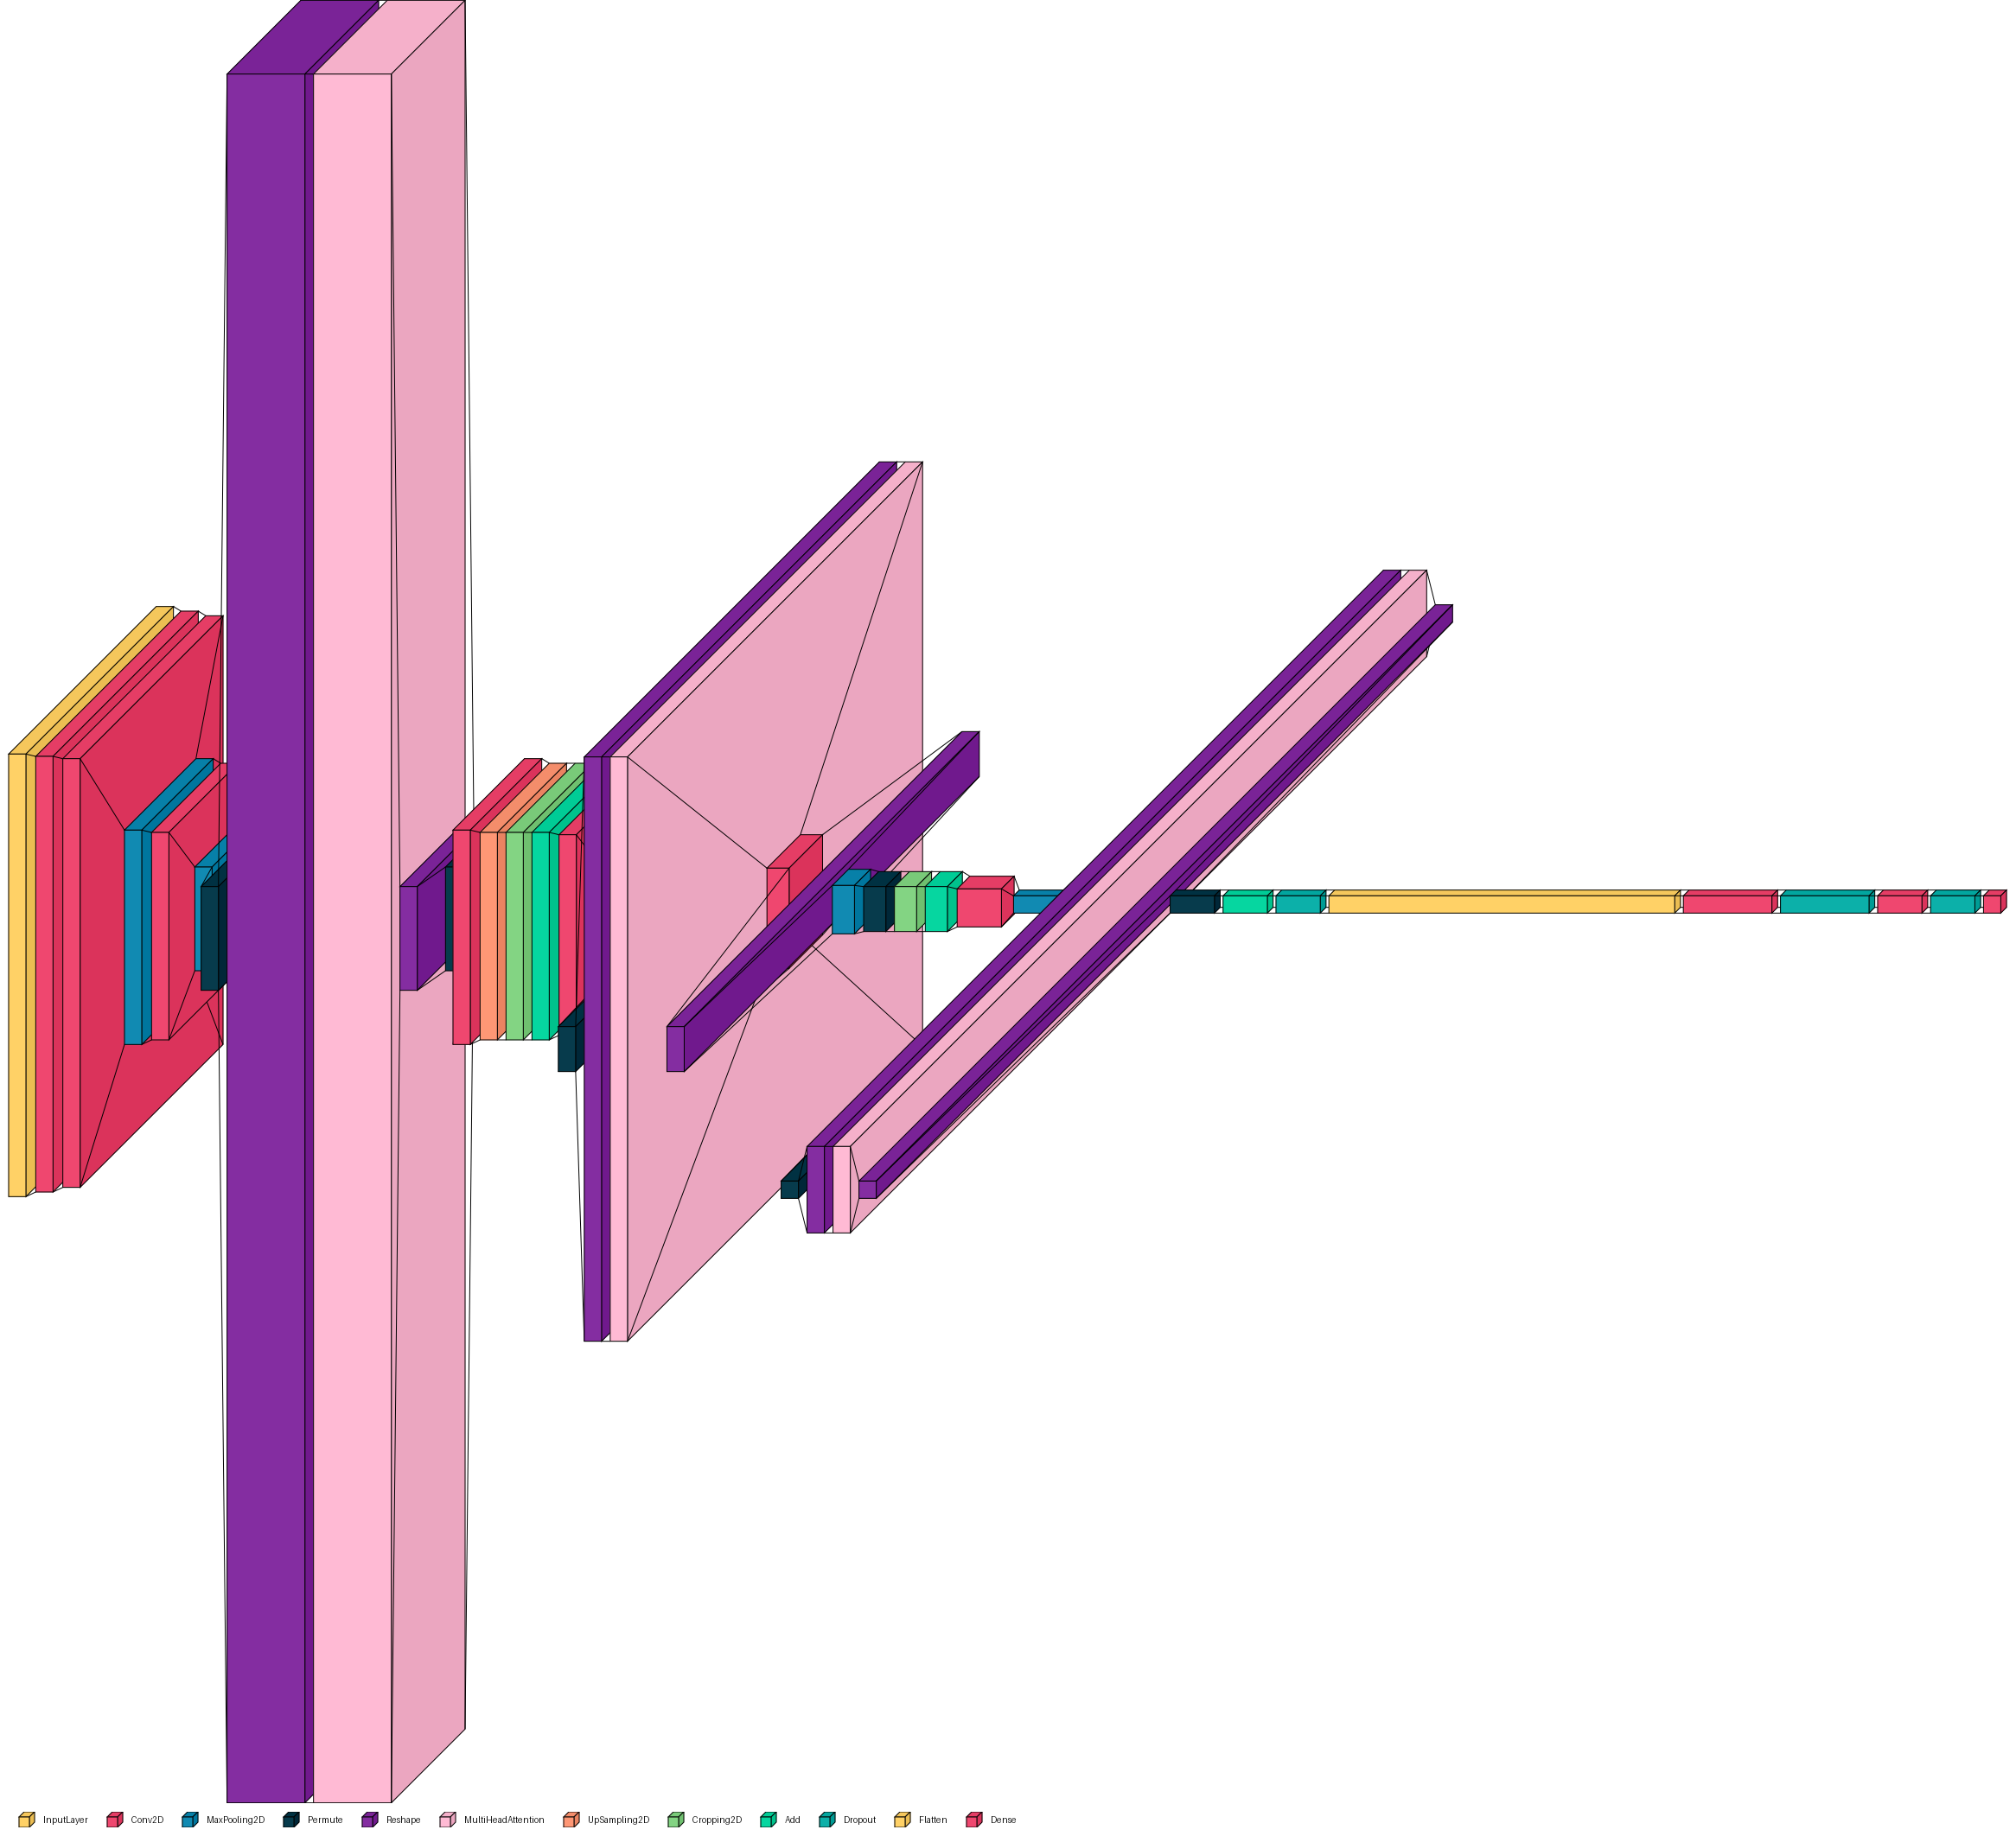

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font

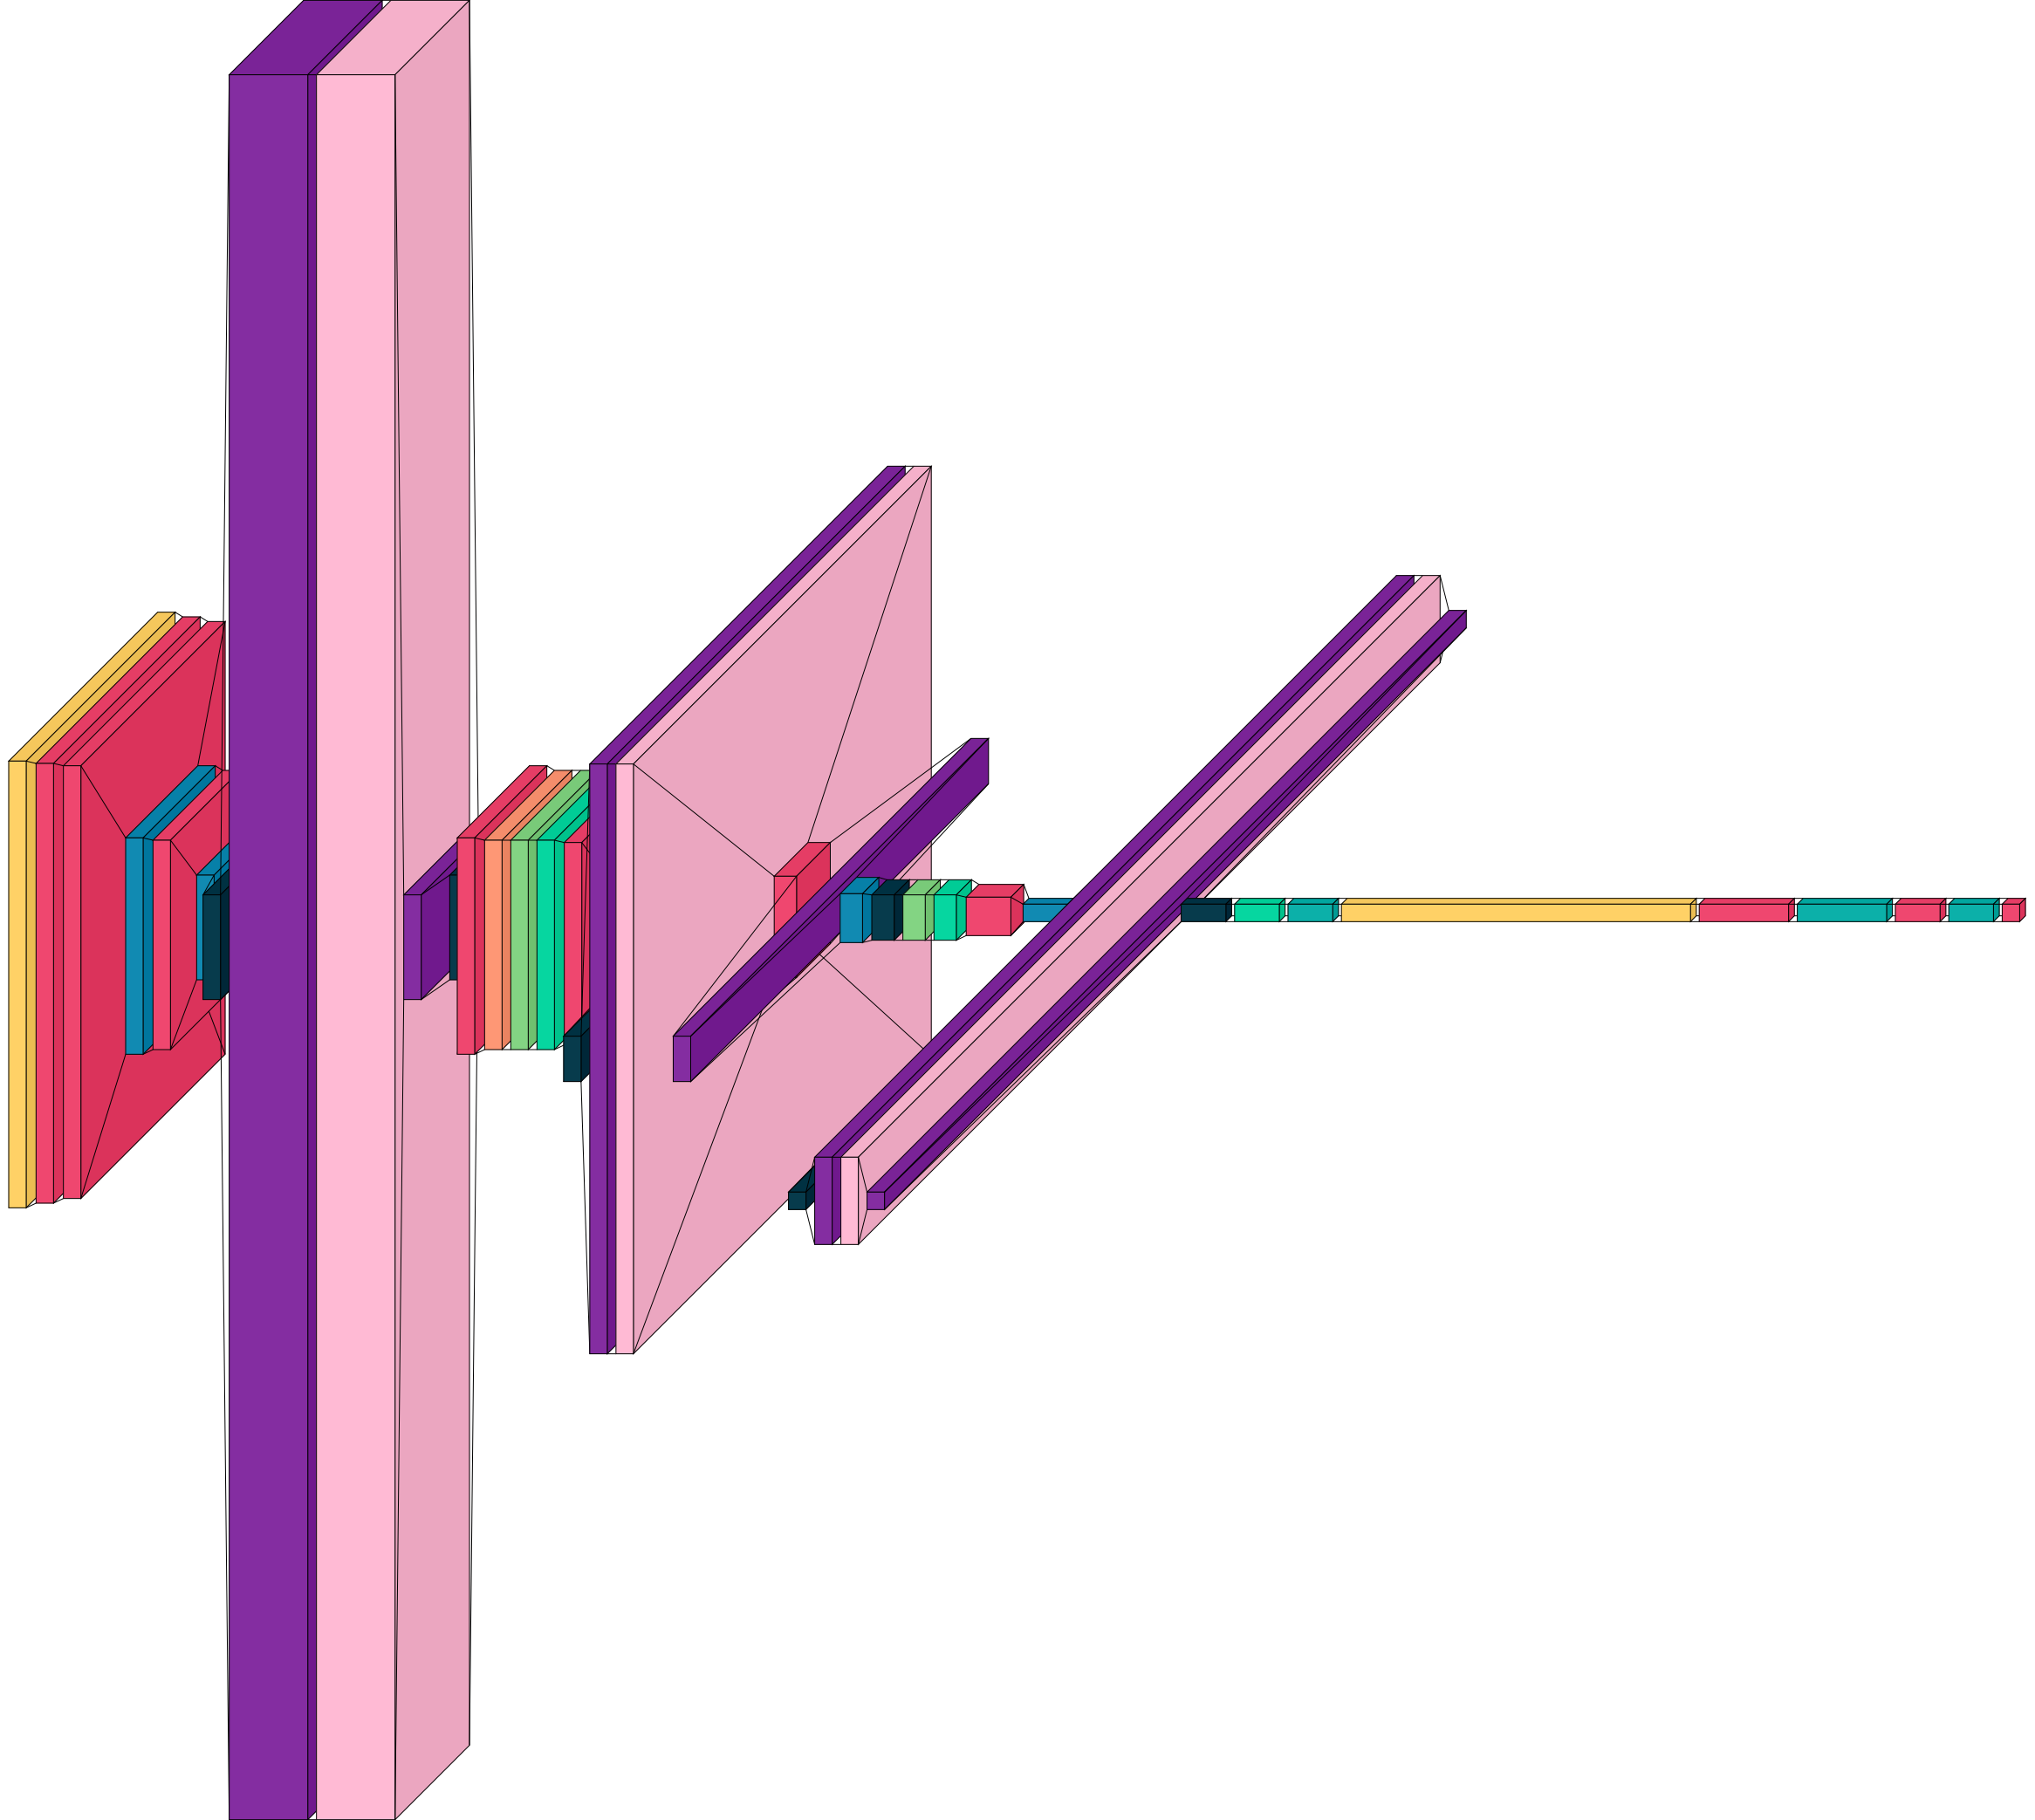

In [ ]:
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [ ]:
y_pred = model.predict(test_dataset)

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step


In [ ]:
y_predict = np.argmax(y_pred,axis=1)
y_predict

array([0, 0, 0, ..., 9, 9, 2], shape=(1200,))

In [ ]:
y_true = test_dataset.classes
y_true

array([0, 0, 0, ..., 9, 9, 9], shape=(1200,), dtype=int32)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
class_name = [
    'Alopecia Areata',
    'Contact Dermatitis',
    'Folliculitis',
    'Head Lice',
    'Lichen Planus',
    'Male Pattern Baldness',
    'Psoriasis',
    'Seborrheic Dermatitis',
    'Telogen Effluvium',
    'Tinea Capitis'
]

In [ ]:
import seaborn as sns

In [ ]:
cm = confusion_matrix(y_true,y_predict)
cm

array([[120,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 117,   1,   0,   0,   0,   2,   0,   0,   0],
       [  0,   0, 120,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 120,   0,   0,   0,   0,   0,   0],
       [  0,   0,   4,   1, 115,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1, 119,   0,   0,   0,   0],
       [  0,   0,   3,   1,   0,   0, 116,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   5, 113,   1,   0],
       [  0,   0,   0,   2,   0,   0,   0,   0, 118,   0],
       [  0,   0,   2,   1,   5,   0,   1,   3,   3, 105]])

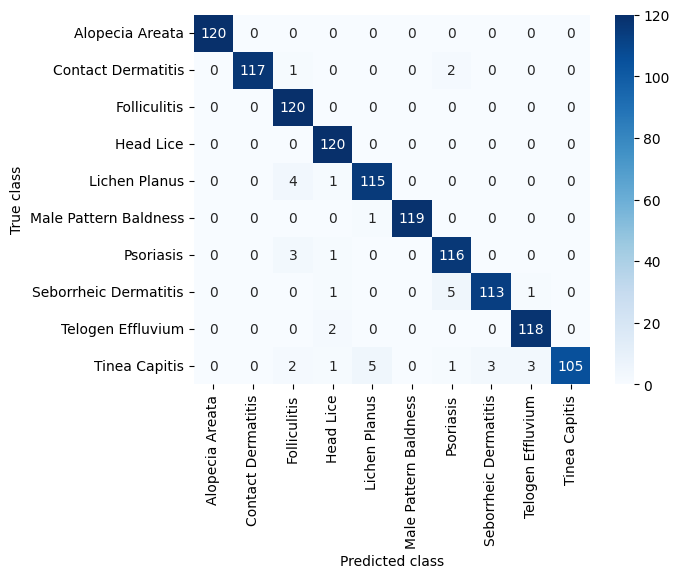

In [ ]:
sns.heatmap(cm, annot=True,xticklabels=class_name, yticklabels=class_name,fmt="d", cmap="Blues")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

In [ ]:
cm_normalized = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
print(cm_normalized)

[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.98 0.01 0.   0.   0.   0.02 0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.03 0.01 0.96 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.01 0.99 0.   0.   0.   0.  ]
 [0.   0.   0.02 0.01 0.   0.   0.97 0.   0.   0.  ]
 [0.   0.   0.   0.01 0.   0.   0.04 0.94 0.01 0.  ]
 [0.   0.   0.   0.02 0.   0.   0.   0.   0.98 0.  ]
 [0.   0.   0.02 0.01 0.04 0.   0.01 0.02 0.02 0.88]]


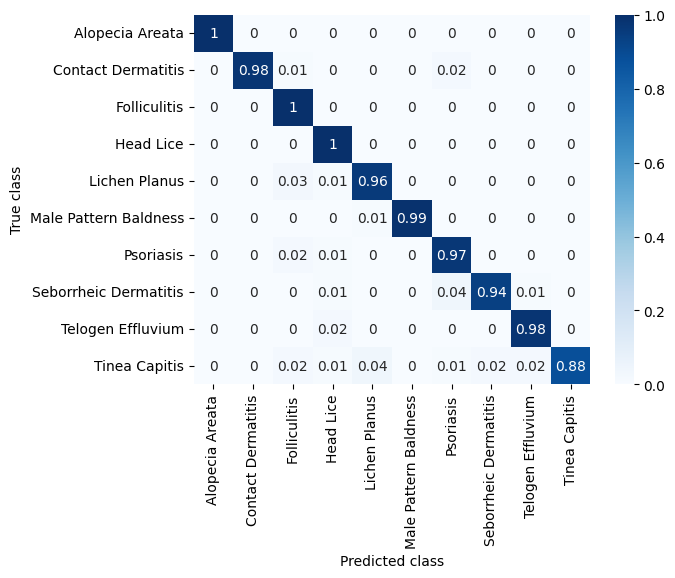

In [ ]:
sns.heatmap(cm_normalized, annot=True,xticklabels=class_name, yticklabels=class_name, cmap="Blues")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

In [1]:
from tensorflow.keras.preprocessing import image as keras_image
import os

# Set the path to your image file
img_path = r"C:\Users\ASUS\OneDrive\Desktop\disease prediction model\Hair Diseases - Final\val\Tinea Capitis\tinea_capitis_0016.jpg"  # <-- Change this to your image file path

if not os.path.exists(img_path):
    print(f"File not found: {img_path}")
else:
    # Load and preprocess the image
    IMAGE_SIZE = 128  # or whatever size you used for training
    img = keras_image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the class
    y_pred = model.predict(img_array)
    predicted_label = np.argmax(y_pred, axis=1)[0]

    # Convert class_name dict to sorted list
    class_list = class_name
    # Display the image and its predicted label
    plt.imshow(img)
    plt.title(f"Predicted: {class_list[predicted_label]}")
    plt.axis('off')
    plt.show()

NameError: name 'np' is not defined

In [ ]:
{
  "cell_type": "code",
  "metadata": {
    "language": "python"
  },
  "source": [
    "# After defining your model architecture (same as training):",
    "model.load_weights('hair-diseases.h5')",
    "print('Weights loaded successfully!')"
  ]
}

{'cell_type': 'code',
 'metadata': {'language': 'python'},
 'source': ['# After defining your model architecture (same as training):',
  "model.load_weights('hair-diseases.h5')",
  "print('Weights loaded successfully!')"]}

In [ ]:
model.load_weights('hair-diseases.h5')
print('Weights loaded successfully!')

Weights loaded successfully!


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras_multi_head import MultiHeadAttention   # 👈 import your custom layer

# Load the model with custom_objects
# model = load_model("hair-diseases.keras", 
                #    custom_objects={"MultiHeadAttention": MultiHeadAttention})

# Define the image size (use the same as during training)
IMAGE_SIZE = 128   # change this to what you used in training (e.g., 128, 224, 256)

# Set the path to your image file
img_path = r"disease1.jpeg"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict the class
y_pred = model.predict(img_array)
predicted_class = np.argmax(y_pred, axis=1)[0]
# If class_name is a dict, get a list of class names sorted by index
class_list = [k for k, v in sorted(class_name.items(), key=lambda item: item[1])]
print("Predicted class:", class_list[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: Tinea Capitis
Predicted class: Tinea Capitis


In [ ]:
# After defining your model architecture (same as training):
model.load_weights('hair-diseases.h5')
print('Weights loaded successfully!')

Weights loaded successfully!
